# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Operaciones de aprendizaje automático (Gpo 10)**

**Tecnológico de Monterrey**

Dr. Gerardo Rodríguez Hernández
Maestro Ricardo Valdez Hernández

### **Actividad: Fase 1 | Avance de Proyecto

**Nombre:** Manuel Alejandro Ambriz Baca

**Matrícula:** A01686824

**Rol:** Data engineer

* #### **Nombre:** Lucero Guadalupe Contreras Hernández
* #### **Matrícula:** A01794502
* #### **Rol:** Data scientist

* #### **Nombre:** Manuel Alejandro Ambriz Baca
* #### **Matrícula:** A01686824
* #### **Rol:** Data Engineer

* #### **Nombre:** Angel Adrian Morales Aldaco
* #### **Matrícula:** A01797072
* #### **Rol:** ML Engineer

* #### **Nombre:** Alberto Cortés Murillo
* #### **Matrícula:** A00739034
* #### **Rol:** DevOps


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

## Configuración básica

In [ ]:


IN_FILE = "/content/drive/MyDrive/OperacionesML/Fase1/data/raw/german_credit_modified.csv"
OUT_DIR = Path("/content/drive/MyDrive/OperacionesML/Fase1/data/interim")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Dominios válidos (categóricas codificadas)
VALID = {
  "laufkont":{1,2,3,4}, "moral":{0,1,2,3,4}, "verw":set(range(0,11)), "sparkont":{1,2,3,4,5},
  "beszeit":{1,2,3,4,5}, "rate":{1,2,3,4}, "famges":{1,2,3,4}, "buerge":{1,2,3},
  "wohnzeit":{1,2,3,4}, "verm":{1,2,3,4}, "weitkred":{1,2,3}, "wohn":{1,2,3},
  "bishkred":{1,2,3,4}, "beruf":{1,2,3,4}, "pers":{1,2}, "telef":{1,2}, "gastarb":{1,2},
  "kredit":{0,1}
}

# Continuas y rangos válidos
CONT = ["hoehe","laufzeit","alter"]
RANGE = {"alter":(18,75), "laufzeit":(4,72), "hoehe":(250,None)}

def brief(df, title="DF"):
    print(f"— {title} — shape={df.shape}, nans={int(df.isna().sum().sum())}, dups={df.duplicated().sum()}")


## Carga y chequeo inicial

In [ ]:
df = pd.read_csv(IN_FILE)

# eliminar si existe columna “ruidosa”
if "mixed_type_col" in df.columns:
    df = df.drop(columns=["mixed_type_col"])

brief(df, "Cargado")

# Vistazo rápido
display(df.head(3))
print("\nTipos:")
print(df.dtypes)
print("\n% faltantes (top 10):")
print((df.isna().mean()*100).round(2).sort_values(ascending=False).head(10))


— Cargado — shape=(1020, 21), nans=247, dups=2


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,...,2.0,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,...,1.0,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,...,1.0,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0



Tipos:
laufkont    object
laufzeit    object
moral       object
verw        object
hoehe       object
sparkont    object
beszeit     object
rate        object
famges      object
buerge      object
wohnzeit    object
verm        object
alter       object
weitkred    object
wohn        object
bishkred    object
beruf       object
pers        object
telef       object
gastarb     object
kredit      object
dtype: object

% faltantes (top 10):
moral       1.67
beszeit     1.67
verw        1.57
kredit      1.57
laufkont    1.47
gastarb     1.47
wohnzeit    1.47
buerge      1.27
beruf       1.18
bishkred    1.18
dtype: float64


## Forzar numérico + validación de dominios/códigos

In [ ]:
# Forzar numérico donde haya strings de números
for c in df.columns:
    if df[c].dtype == "O":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Contar códigos inválidos y convertirlos a NaN
invalid_counts = {}
for col, ok in VALID.items():
    if col in df.columns:
        m = df[col].notna() & ~df[col].isin(ok)
        invalid_counts[col] = int(m.sum())
        df.loc[m, col] = np.nan

print("Códigos inválidos (solo no-cero):", {k:v for k,v in invalid_counts.items() if v})
brief(df, "Tras coerción + dominios")


Códigos inválidos (solo no-cero): {'laufkont': 13, 'moral': 18, 'verw': 9, 'sparkont': 9, 'beszeit': 7, 'rate': 4, 'famges': 5, 'buerge': 12, 'wohnzeit': 10, 'verm': 8, 'weitkred': 10, 'wohn': 9, 'bishkred': 14, 'beruf': 17, 'pers': 14, 'telef': 5, 'gastarb': 13, 'kredit': 8}
— Tras coerción + dominios — shape=(1020, 21), nans=506, dups=7


## Reglas de rango + outliers en ‘hoehe’ (IQR con piso)

In [ ]:
# Reglas de rango (se dejan como NaN lo fuera de rango)
for col,(lo,hi) in RANGE.items():
    if col in df.columns:
        if lo is not None: df.loc[df[col] < lo, col] = np.nan
        if hi is not None: df.loc[df[col] > hi, col] = np.nan

# Filtrado IQR en 'hoehe' con piso HOEHE>=250
removed_iqr = 0
if "hoehe" in df.columns and df["hoehe"].notna().any():
    s = df["hoehe"].dropna()
    q1,q3 = s.quantile([.25,.75]); iqr = q3-q1
    low, high = max(q1-1.5*iqr, 250), q3+1.5*iqr
    m = df["hoehe"].between(low, high)
    removed_iqr = int((~m).sum())
    df = df[m].copy()

print(f"Outliers eliminados en 'hoehe' por IQR: {removed_iqr}")
brief(df, "Tras rangos + IQR")


Outliers eliminados en 'hoehe' por IQR: 88
— Tras rangos + IQR — shape=(932, 21), nans=463, dups=6


## Target binario consistente + imputaciones simples

In [ ]:
# Mapear target a 'target_bad' (1 = malo, 0 = bueno)
if "kredit" not in df.columns:
    raise ValueError("Falta columna 'kredit' (target)")

df["target_bad"] = df["kredit"].map({1:0, 0:1}).astype("Int64")

# Imputaciones: medianas para continuas, moda para categóricas
df_imp = df.copy()
for c in df_imp.columns:
    if c == "target_bad":
        continue
    if c in CONT:
        df_imp[c] = df_imp[c].fillna(df_imp[c].median())
    else:
        moda = df_imp[c].mode(dropna=True)
        if not moda.empty:
            df_imp[c] = df_imp[c].fillna(moda.iloc[0])

# Opcional: quitar la columna original 'kredit' (ya tenemos target_bad)
if "kredit" in df_imp.columns:
    df_imp = df_imp.drop(columns=["kredit"])

brief(df_imp, "Tras imputación")
print("Distribución target_bad (proporción):")
print(df_imp["target_bad"].value_counts(normalize=True).round(3))


— Tras imputación — shape=(932, 21), nans=23, dups=9
Distribución target_bad (proporción):
target_bad
0    0.715
1    0.285
Name: proportion, dtype: Float64


## Duplicados (exactos y conflictivos)

In [ ]:
before = len(df_imp)
df_imp = df_imp.drop_duplicates().reset_index(drop=True)
removed_exact = before - len(df_imp)

# Duplicados conflictivos: mismas features con distinto target
feats = [c for c in df_imp.columns if c != "target_bad"]
g = df_imp.groupby(feats, dropna=False)["target_bad"].nunique()
conflict_keys = set(g[g > 1].index)

removed_conflict = 0
if conflict_keys:
    df_imp["__key__"] = list(map(tuple, df_imp[feats].values))
    keep_mask = ~df_imp["__key__"].isin(conflict_keys)
    removed_conflict = int((~keep_mask).sum())
    df_imp = df_imp.loc[keep_mask].drop(columns="__key__").reset_index(drop=True)

print(f"Duplicados exactos eliminados: {removed_exact}")
print(f"Duplicados conflictivos eliminados: {removed_conflict}")
brief(df_imp, "Final sin duplicados")


Duplicados exactos eliminados: 9
Duplicados conflictivos eliminados: 0
— Final sin duplicados — shape=(923, 21), nans=23, dups=0


## Guardar + QC rápido

In [ ]:


out_csv = OUT_DIR / "german_credit_clean.csv"
out_qc  = OUT_DIR / "qc_report.json"

df_imp.to_csv(out_csv, index=False)

# ---- helpers para JSON seguro ----
def json_key(k):
    # normaliza claves a tipos nativos
    if isinstance(k, (np.integer,)):
        return int(k)
    if isinstance(k, (np.floating,)):
        return float(k)
    if pd.isna(k):
        return "NaN"
    return k

def json_val(v):
    # valores seguros (por si vienen como numpy.*)
    if isinstance(v, (np.integer,)):
        return int(v)
    if isinstance(v, (np.floating,)):
        return float(v)
    return v

# construir QC con claves/valores seguros
missing_pct = {str(k): json_val(v) for k, v in (df_imp.isna().mean()*100).round(2).to_dict().items()}

tb = df_imp["target_bad"].value_counts(normalize=True).round(3).to_dict()
target_balance = {json_key(k): json_val(v) for k, v in tb.items()}

qc = {
    "shape": [int(df_imp.shape[0]), int(df_imp.shape[1])],
    "missing_pct": missing_pct,
    "target_balance": target_balance,
    "dups_remaining": int(df_imp.duplicated().sum())
}

with open(out_qc, "w", encoding="utf-8") as f:
    json.dump(qc, f, indent=2, ensure_ascii=False)

print(f"[OK] Guardado: {out_csv}")
print(json.dumps(qc, indent=2, ensure_ascii=False))


[OK] Guardado: /content/drive/MyDrive/OperacionesML/Fase1/data/interim/german_credit_clean.csv
{
  "shape": [
    923,
    21
  ],
  "missing_pct": {
    "laufkont": 0.0,
    "laufzeit": 0.0,
    "moral": 0.0,
    "verw": 0.0,
    "hoehe": 0.0,
    "sparkont": 0.0,
    "beszeit": 0.0,
    "rate": 0.0,
    "famges": 0.0,
    "buerge": 0.0,
    "wohnzeit": 0.0,
    "verm": 0.0,
    "alter": 0.0,
    "weitkred": 0.0,
    "wohn": 0.0,
    "bishkred": 0.0,
    "beruf": 0.0,
    "pers": 0.0,
    "telef": 0.0,
    "gastarb": 0.0,
    "target_bad": 2.49
  },
  "target_balance": {
    "0": 0.717,
    "1": 0.283
  },
  "dups_remaining": 0
}


## Celda de verificación previa al EDA

In [ ]:
path = "/content/drive/MyDrive/OperacionesML/Fase1/data/interim/german_credit_clean.csv"

df = pd.read_csv(path)
print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
print("\nValores nulos por columna (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))
print("\nDistribución target_bad:")
print(df["target_bad"].value_counts(normalize=True).round(3))


Shape: (923, 21)
Columnas: ['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'target_bad']

Valores nulos por columna (top 10):
target_bad    23
laufzeit       0
moral          0
verw           0
laufkont       0
hoehe          0
sparkont       0
rate           0
beszeit        0
buerge         0
dtype: int64

Distribución target_bad:
target_bad
0.0    0.717
1.0    0.283
Name: proportion, dtype: float64


## Paths, librerías y semilla

In [ ]:
import os, joblib, textwrap
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)


BASE = Path("/content/drive/MyDrive/OperacionesML/Fase1")

DVC_DIR  = BASE / "data"                 # datasets versionados
DATA_DIR = DVC_DIR / "interim"            # german_credit_clean.csv esta aqui
ARTI_DIR = BASE / "artifacts"            # para guardar modelos/figuras/métricas
for p in [DATA_DIR, ARTI_DIR, DVC_DIR]: p.mkdir(parents=True, exist_ok=True)

IN_FILE = BASE / "data/interim/german_credit_clean.csv"
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = ARTI_DIR / f"run_{RUN_ID}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Archivo de entrada:", IN_FILE)
print("Run dir:", RUN_DIR)



Archivo de entrada: /content/drive/MyDrive/OperacionesML/Fase1/data/interim/german_credit_clean.csv
Run dir: /content/drive/MyDrive/OperacionesML/Fase1/artifacts/run_20251012_202156


## Cargar datos y chequeos rápidos

In [ ]:


df = pd.read_csv(IN_FILE)
print("Shape:", df.shape)
display(df.head(5))

print("\nTipos:")
display(df.dtypes)

print("\nNulos por columna (top 10):")
display(df.isna().sum().sort_values(ascending=False).head(10))

print("Duplicados:", df.duplicated().sum())
print("\nDistribución target_bad:")
display(df["target_bad"].value_counts(normalize=True).round(3))


Shape: (923, 21)


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,target_bad
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,...,2.0,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,...,1.0,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,0.0
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,...,1.0,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,0.0
3,1.0,12.0,4.0,0.0,2122.0,1.0,3.0,3.0,3.0,1.0,...,1.0,39.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0
4,1.0,12.0,4.0,0.0,2171.0,1.0,3.0,4.0,3.0,1.0,...,2.0,38.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0



Tipos:


,0
laufkont,float64
laufzeit,float64
moral,float64
verw,float64
hoehe,float64
sparkont,float64
beszeit,float64
rate,float64
famges,float64
buerge,float64



Nulos por columna (top 10):


,0
target_bad,23
laufzeit,0
moral,0
verw,0
laufkont,0
hoehe,0
sparkont,0
rate,0
beszeit,0
buerge,0


Duplicados: 0

Distribución target_bad:


,proportion
target_bad,
0.0,0.717
1.0,0.283


## Reglas de dominio y rango

In [ ]:
VALID = {
    "laufkont":{1,2,3,4},"moral":{0,1,2,3,4},"verw":set(range(0,11)),"sparkont":{1,2,3,4,5},
    "beszeit":{1,2,3,4,5},"rate":{1,2,3,4},"famges":{1,2,3,4},"buerge":{1,2,3},
    "wohnzeit":{1,2,3,4},"verm":{1,2,3,4},"weitkred":{1,2,3},"wohn":{1,2,3},
    "bishkred":{1,2,3,4},"beruf":{1,2,3,4},"pers":{1,2},"telef":{1,2},"gastarb":{1,2}
}
RANGE = {"alter":(18,75),"laufzeit":(4,72),"hoehe":(250,None)}

invalid_nonzero = {}
for col, dom in VALID.items():
    if col in df.columns:
        invalid_nonzero[col] = int((~df[col].isin(dom)).sum())
invalid_nonzero = {k:v for k,v in invalid_nonzero.items() if v>0}

range_viol = {}
for col,(lo,hi) in RANGE.items():
    if col in df.columns:
        m = ((lo is not None) & (df[col] < lo)) | ((hi is not None) & (df[col] > hi))
        range_viol[col] = int(m.sum())
range_viol = {k:v for k,v in range_viol.items() if v>0}

print("Invalid codes (non-zero):", invalid_nonzero)
print("Range violations (non-zero):", range_viol)


Invalid codes (non-zero): {}
Range violations (non-zero): {}


##EDA básico (distribuciones y correlaciones)

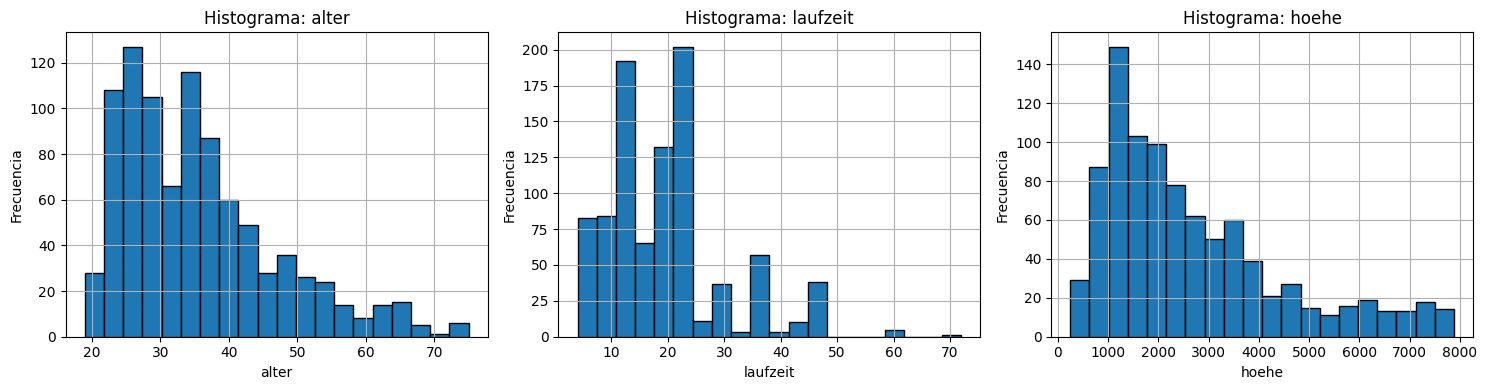

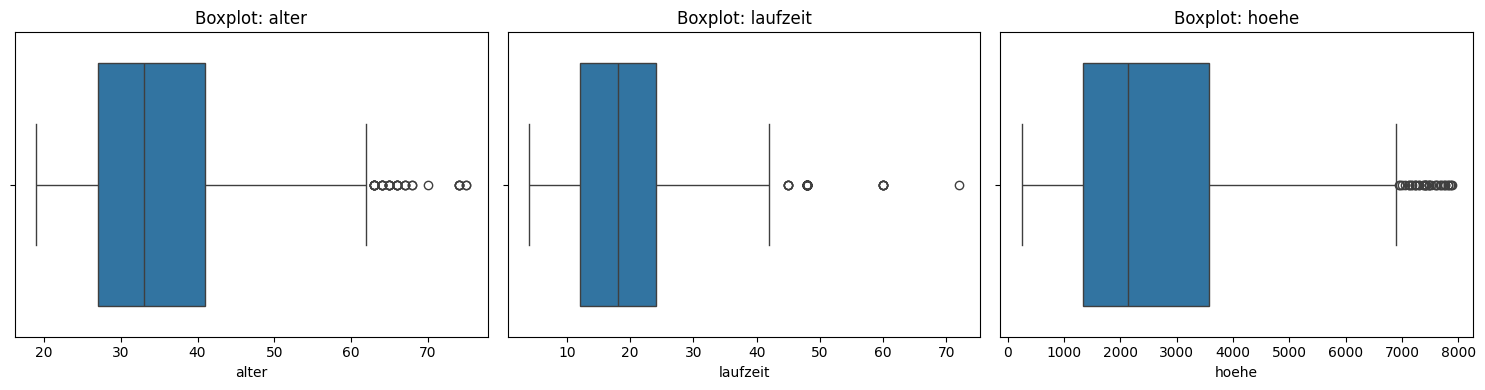

,target_bad
target_bad,1.000000
laufzeit,0.230866
verm,0.113935
rate,0.111665
gastarb,0.100970
hoehe,0.061424
verw,0.003789
beruf,-0.000394
pers,-0.003213
wohnzeit,-0.007259


Guardado: correlaciones vs target en /content/drive/MyDrive/OperacionesML/Fase1/artifacts/run_20251012_202156/corr_vs_target.csv


,count
laufkont,
4.0,383
1.0,249
2.0,230
3.0,61


,count
moral,
2.0,507
4.0,270
3.0,72
1.0,44
0.0,30


,count
verw,
3.0,290
0.0,206
2.0,172
9.0,85
1.0,79
6.0,43
5.0,20
4.0,12
8.0,9


,count
sparkont,
1.0,568
5.0,160
2.0,93
3.0,57
4.0,45


,count
beszeit,
3.0,329
5.0,227
2.0,158
4.0,156
1.0,53


,count
rate,
4.0,469
2.0,188
3.0,147
1.0,119


In [ ]:
import math


cont_cols = [c for c in ["alter","laufzeit","hoehe"] if c in df.columns]
cat_cols  = [c for c in VALID.keys() if c in df.columns]

# --- MODIFICADO: Histogramas en una rejilla de 3 columnas ---
n_cols = 3
n_rows = math.ceil(len(cont_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, c in enumerate(cont_cols):
    ax = axes[i]
    df[c].hist(ax=ax, bins=20, edgecolor="black")
    ax.set_title(f"Histograma: {c}")
    ax.set_xlabel(c); ax.set_ylabel("Frecuencia")

# Ocultar ejes no utilizados
for i in range(len(cont_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig(RUN_DIR / "hists_continuas.png", bbox_inches="tight")
plt.show()


# --- MODIFICADO: Boxplots en una rejilla de 3 columnas ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, c in enumerate(cont_cols):
    ax = axes[i]
    sns.boxplot(x=df[c], ax=ax)
    ax.set_title(f"Boxplot: {c}")

# Ocultar ejes no utilizados
for i in range(len(cont_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig(RUN_DIR / "boxplots_continuas.png", bbox_inches="tight")
plt.show()

# Correlación con target
corr = df.corr(numeric_only=True)["target_bad"].sort_values(ascending=False)
display(corr)

corr.to_csv(RUN_DIR / "corr_vs_target.csv")
print("Guardado: correlaciones vs target en", RUN_DIR / "corr_vs_target.csv")

# Conteos de categóricas (muestra)
for c in cat_cols[:6]:
    vc = df[c].value_counts(dropna=False)
    display(vc)
    vc.to_csv(RUN_DIR / f"value_counts_{c}.csv")


Los histogramas y boxplots de las variables numéricas nos pintan un cuadro muy consistente:


*   Edad (alter): La mayoría de los solicitantes son jóvenes, concentrados principalmente entre los 20 y 40 años. La distribución está sesgada hacia la derecha, lo que significa que hay menos solicitantes a medida que la edad aumenta. Los outliers (puntos atípicos) en el boxplot confirman que hay algunas personas de edad avanzada, pero son la excepción.
*   Monto del Crédito (hoehe): La gran mayoría de los créditos solicitados son de montos bajos (probablemente menos de 3,000). La distribución está fuertemente sesgada a la derecha, indicando que muy pocos créditos son por montos altos. Esto es típico en datos financieros.
*   Duración del Crédito (laufzeit): Los solicitantes prefieren plazos de corta a mediana duración. Los picos en el histograma sugieren que los plazos más populares son los estándares, como 12, 24 y 36 meses. Al igual que las otras variables, está sesgada a la derecha, con algunos créditos a plazos muy largos que se consideran atípicos.


Conclusión Parcial: El solicitante típico es una persona joven que pide un préstamo relativamente pequeño a un plazo estándar.

# Conclusiones Clave para el Modelo de Riesgo
Los Ahorros son un Factor Crítico: El hecho de que la mayoría de los clientes tengan pocos ahorros es probablemente uno de los predictores más fuertes de riesgo. Un solicitante sin un colchón financiero es más vulnerable a un impago si surge un imprevisto.

El Sesgo es la Norma: Todas tus variables numéricas están sesgadas. Esto es importante porque algunos modelos de machine learning funcionan mejor si los datos se asemejan a una distribución normal. Podrías necesitar aplicar transformaciones (como la transformación logarítmica) al monto del crédito (hoehe) más adelante.

Tensión entre Estabilidad y Riesgo: Existe una interesante dualidad: los solicitantes suelen tener empleos estables, pero al mismo tiempo tienen pocos ahorros y aceptan altas tasas de pago. Tu modelo deberá aprender a ponderar estos factores opuestos para determinar el riesgo real.

Los Outliers son Relevantes: Los boxplots muestran claramente que existen solicitantes con edades, montos y plazos de crédito muy por encima de la media. Es importante que tu modelo sea robusto frente a estos outliers o que decidas cómo tratarlos.

## Outliers IQR (reporte, sin modificar datos)
detectar y contar los valores atípicos (outliers) en las columnas numéricas

In [ ]:
def iqr_bounds(s, min_floor=None):
    q1,q3 = s.quantile([0.25,0.75])
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    if min_floor is not None:
        low = max(low, min_floor)
    return low, high

out_report = {}
for c in cont_cols:
    low, high = iqr_bounds(df[c].dropna(), min_floor=RANGE.get(c,(None,None))[0])
    cnt = int(((df[c] < low) | (df[c] > high)).sum())
    out_report[c] = {"low":float(low), "high":float(high), "outliers":cnt}
out_path = RUN_DIR / "outliers_iqr.json"
json.dump(out_report, open(out_path,"w"), indent=2)
print(json.dumps(out_report, indent=2))
print("Guardado:", out_path)


{
  "alter": {
    "low": 18.0,
    "high": 62.0,
    "outliers": 34
  },
  "laufzeit": {
    "low": 4.0,
    "high": 42.0,
    "outliers": 44
  },
  "hoehe": {
    "low": 250.0,
    "high": 6915.75,
    "outliers": 36
  }
}
Guardado: /content/drive/MyDrive/OperacionesML/Fase1/artifacts/run_20251012_202156/outliers_iqr.json



*   Para alter (Edad):

El rango de edad considerado "normal" por este método es entre 18.0 y 62.0 años.

Se encontraron 34 solicitantes con una edad superior a 62, los cuales son marcados como valores atípicos.

*   Para laufzeit (Duración del Crédito):

El rango de duración "normal" es entre 4.0 y 42.0 meses.

Se encontraron 44 créditos con una duración mayor a 42 meses (más de 3.5 años), que son considerados atípicos.
*   Para hoehe (Monto del Crédito):

El rango de monto "normal" es entre 250.0 y 6,915.75.

Se encontraron 36 préstamos solicitados por un monto superior a 6,915.75, marcándolos como atípicos.







## Preprocesamiento (imputación simple + escalado) y split

In [ ]:
# Copia para asegurar 0 duplicados
df2 = df.drop_duplicates().copy()

# --- Imputación SOLO en features (no tocar el target) ---
for col in df2.columns:
    if col == "target_bad":
        continue
    if col in cont_cols:          # continuas: mediana
        df2[col] = df2[col].fillna(df2[col].median())
    else:                         # categóricas: moda
        moda = df2[col].mode(dropna=True)
        if not moda.empty:
            df2[col] = df2[col].fillna(moda.iloc[0])

# --- Asegurar que el target sea válido (0/1) y sin NaN ---
n_target_na = int(df2["target_bad"].isna().sum())
if n_target_na > 0:
    print(f"Eliminando {n_target_na} filas con target_bad = NaN")
    df2 = df2.dropna(subset=["target_bad"]).copy()

vals = set(df2["target_bad"].unique())
if not vals <= {0, 1}:
    raise ValueError(f"Valores no binarios en target_bad: {sorted(vals)}")

print("NA totales tras imputación (solo features):", int(df2.drop(columns=["target_bad"]).isna().sum().sum()))

# --- Construir X, y ---
X = df2.drop(columns=["target_bad"])
y = df2["target_bad"].astype("int64")   # ya no debe fallar

# --- Escalado solo en continuas ---
scaler = StandardScaler()
X_scaled = X.copy()
if cont_cols:
    X_scaled[cont_cols] = scaler.fit_transform(X_scaled[cont_cols])

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Distribución y:", y.value_counts(normalize=True).round(3).to_dict())

# --- Guardar dataset listo ---
ready = X_scaled.copy()
ready["target_bad"] = y.values
ready_path = DATA_DIR / "analysis_ready.csv" #dataset listo para entrenamiento
ready.to_csv(ready_path, index=False)
print("[OK] analysis_ready ->", ready_path)



Eliminando 23 filas con target_bad = NaN
NA totales tras imputación (solo features): 0
Train: (675, 20)  Test: (225, 20)
Distribución y: {0: 0.717, 1: 0.283}
[OK] analysis_ready -> /content/drive/MyDrive/OperacionesML/Fase1/data/interim/analysis_ready.csv


## Interación con DVC

In [ ]:
!pip -q install mlflow==2.16.0 dvc[gdrive]==3.55.2 dvc[s3]==3.55.2 scikit-learn==1.5.2 pyyaml==6.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.8/438.8 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5

In [ ]:
import pathlib
pathlib.Path(BASE).mkdir(parents=True, exist_ok=True)
os.chdir(BASE)
!pwd

/content/drive/MyDrive/OperacionesML/Fase1


In [ ]:
%%bash
dvc remote add -d gdrive gdrive://1E494khYq8ookdJWNncl7o2j6vHrlDHvg
git add .dvc/config
git commit -m "add dvc remote gdrive"

In [ ]:
%%bash
cat > params.yaml << 'EOF'
data:
  raw_path: data/raw/german_credit_modified.csv
  clean_path: data/interim/analysis_ready.csv
  processed_path: data/processed/train.csv
model:
  type: "RandomForestClassifier"   # tipo de modelo
  test_size: 0.2
  random_state: 42
  n_estimators: 300
  max_depth: null
  n_jobs: -1
  class_weight: "balanced"         # útil si hay desbalance
target: "target_bad"               # <- tu variable objetivo
features: []                       # si vacío, usa todas menos target
experiment_name: "fase1-colab-mlflow"
EOF

In [ ]:
%%bash
mkdir -p src notebooks models

In [ ]:
%%bash
cat > src/utils.py << 'PY'
import yaml
from pathlib import Path

def load_params(path: str = "params.yaml"):
    """Lee los parámetros globales del proyecto."""
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def ensure_parent(p: str):
    """Crea carpetas padre si no existen."""
    Path(p).parent.mkdir(parents=True, exist_ok=True)
PY

In [ ]:
%%bash
cat > src/preprocessing.py << 'PY'
import pandas as pd
from utils import load_params, ensure_parent

def make_trainset():
    """Toma el dataset limpio, aplica transformaciones y genera el dataset procesado."""
    P = load_params()
    clean_path = P["data"]["clean_path"]
    out_path = P["data"]["processed_path"]
    target = P["target"]
    feats = P.get("features") or []

    # Cargar dataset limpio (ya depurado en tu EDA)
    df = pd.read_csv(clean_path)

    # Si no hay lista de features, usar todas menos la variable objetivo
    if not feats:
        feats = [c for c in df.columns if c != target]

    # Aquí podrías agregar transformaciones extra si lo necesitas
    # Ejemplo: encoding, normalización, etc.
    # df = pd.get_dummies(df, drop_first=True)

    # Guardar dataset final procesado
    ensure_parent(out_path)
    df[feats + [target]].to_csv(out_path, index=False)
    print(f"✅ Dataset procesado guardado en: {out_path}")

if __name__ == "__main__":
    make_trainset()
PY

In [ ]:
!python src/preprocessing.py

✅ Dataset procesado guardado en: data/processed/train.csv


In [ ]:
%%bash
git add data/raw/german_credit_modified.csv data/interim/german_credit_clean.csv src params.yaml
git commit -m "add initial data and preprocessing pipeline"

[master f1f66c5] add initial data and preprocessing pipeline
 2 files changed, 1 insertion(+), 1 deletion(-)


## Baseline: Regresión Logística (class_weight balanced)

Este código entrena un modelo base de Regresión Logística, lo evalúa a fondo y guarda los resultados.

Baseline (LogReg) ROC-AUC: 0.8625776397515528
Baseline (LogReg) PR-AUC : 0.7284255931959087

Classification report:
              precision    recall  f1-score   support

           0      0.910     0.752     0.823       161
           1      0.565     0.812     0.667        64

    accuracy                          0.769       225
   macro avg      0.737     0.782     0.745       225
weighted avg      0.812     0.769     0.779       225

Confusion matrix:
 [[121  40]
 [ 12  52]]


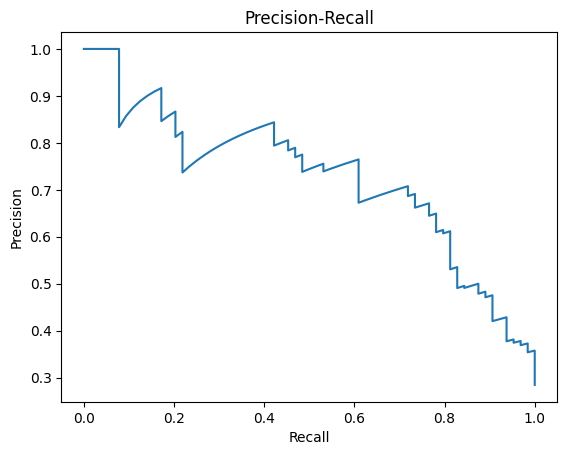

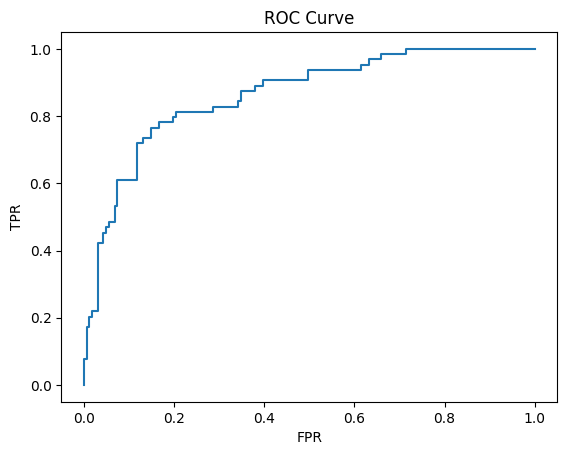

Guardado modelo y métricas en /content/drive/MyDrive/OperacionesML/Fase1/artifacts/run_20251012_202156


In [ ]:
logit = LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE)
logit.fit(X_train, y_train)

proba = logit.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "roc_auc": float(roc_auc_score(y_test, proba)),
    "pr_auc": float(average_precision_score(y_test, proba)),
}
print("Baseline (LogReg) ROC-AUC:", metrics["roc_auc"])
print("Baseline (LogReg) PR-AUC :", metrics["pr_auc"])

print("\nClassification report:")
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
print("Confusion matrix:\n", cm)

# Curvas y figuras
prec, rec, thr = precision_recall_curve(y_test, proba)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.savefig(RUN_DIR / "pr_curve_logit.png", bbox_inches="tight"); plt.show()

fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.savefig(RUN_DIR / "roc_curve_logit.png", bbox_inches="tight"); plt.show()

# Guardar métricas y modelo
json.dump(metrics, open(RUN_DIR / "metrics_logit.json","w"), indent=2)
joblib.dump(logit, RUN_DIR / "model_logit.joblib")
print("Guardado modelo y métricas en", RUN_DIR)



*   Curva Precision-Recall

Esta curva muestra el compromiso (trade-off) del mundo real.

A la izquierda (bajo Recall), la precisión es alta. Esto significa que cuando el modelo está muy seguro de que alguien es un mal pagador, casi siempre acierta. Sin embargo, en este punto solo está identificando a unos pocos de todos los malos pagadores que existen.
*   Curva ROC

El modelo tiene una excelente capacidad para discriminar entre un cliente bueno y uno malo.








## Modelo 2: Random Forest + GridSearchCV (ajuste de hiperparámetros)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores params RF: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mejor score CV (PR-AUC): 0.6299448723592913
RF ROC-AUC: 0.8497670807453417
RF PR-AUC : 0.7000063752344102

Classification report (RF):
              precision    recall  f1-score   support

           0      0.855     0.845     0.850       161
           1      0.621     0.641     0.631        64

    accuracy                          0.787       225
   macro avg      0.738     0.743     0.740       225
weighted avg      0.789     0.787     0.788       225

Confusion matrix (RF):
 [[136  25]
 [ 23  41]]


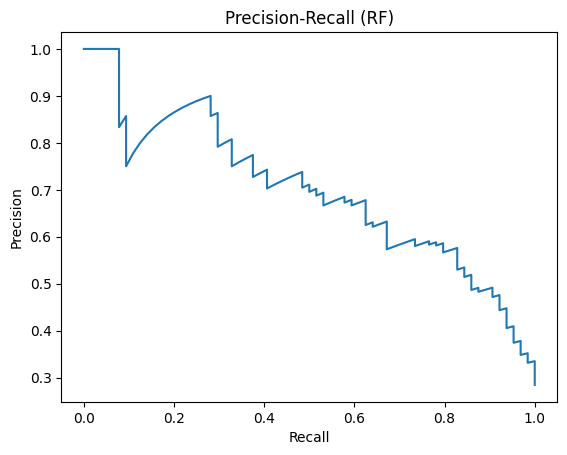

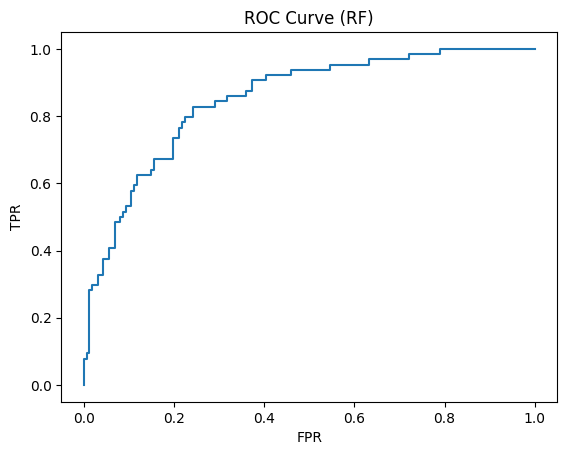

Guardado RF y métricas en /content/drive/MyDrive/OperacionesML/Fase1/artifacts/run_20251012_202156


In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
g = GridSearchCV(rf, param_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
g.fit(X_train, y_train)

best_rf = g.best_estimator_
print("Mejores params RF:", g.best_params_)
print("Mejor score CV (PR-AUC):", g.best_score_)

proba_rf = best_rf.predict_proba(X_test)[:,1]
pred_rf  = (proba_rf >= 0.5).astype(int)

metrics_rf = {
    "roc_auc": float(roc_auc_score(y_test, proba_rf)),
    "pr_auc": float(average_precision_score(y_test, proba_rf)),
}
print("RF ROC-AUC:", metrics_rf["roc_auc"])
print("RF PR-AUC :", metrics_rf["pr_auc"])
print("\nClassification report (RF):")
print(classification_report(y_test, pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, pred_rf)
print("Confusion matrix (RF):\n", cm_rf)

# Figuras
prec, rec, thr = precision_recall_curve(y_test, proba_rf)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall (RF)")
plt.savefig(RUN_DIR / "pr_curve_rf.png", bbox_inches="tight"); plt.show()

fpr, tpr, _ = roc_curve(y_test, proba_rf)
plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve (RF)")
plt.savefig(RUN_DIR / "roc_curve_rf.png", bbox_inches="tight"); plt.show()

# Guardado
json.dump({"best_params": g.best_params_, "cv_best_pr_auc": g.best_score_},
          open(RUN_DIR / "rf_tuning_summary.json","w"), indent=2)
json.dump(metrics_rf, open(RUN_DIR / "metrics_rf.json","w"), indent=2)
joblib.dump(best_rf, RUN_DIR / "model_rf.joblib")
print("Guardado RF y métricas en", RUN_DIR)


Observa cómo la curva empieza en Precision = 1.0 y se mantiene ahí por un tramo. Esto es muy valioso y significa que el modelo es capaz de identificar un grupo de solicitantes (aproximadamente el 10% de los malos pagadores) con una precisión prácticamente perfecta.

## Comparación de modelos

In [ ]:
m_log = json.load(open(RUN_DIR / "metrics_logit.json"))
m_rf  = json.load(open(RUN_DIR / "metrics_rf.json"))

comp = pd.DataFrame([
    {"modelo":"LogReg", "roc_auc":m_log["roc_auc"], "pr_auc":m_log["pr_auc"]},
    {"modelo":"RandomForest", "roc_auc":m_rf["roc_auc"], "pr_auc":m_rf["pr_auc"]},
]).sort_values("pr_auc", ascending=False)
display(comp)

comp.to_csv(RUN_DIR / "models_comparison.csv", index=False)

# Model card mínima
card = f"""
# Model Card — German Credit (run {RUN_ID})

## Datos
- Fuente: german_credit_clean.csv
- Tamaño: {df.shape}
- Target: target_bad (1=riesgo alto)

## Preprocesamiento
- Imputación simple (mediana/mode).
- Escalado: StandardScaler en continuas (alter, laufzeit, hoehe).
- Split: 75/25 estratificado, random_state={RANDOM_STATE}.

## Modelos
- Baseline: LogisticRegression(class_weight='balanced').
- Tuning: RandomForest (GridSearchCV, PR-AUC).

## Métricas (test)
- LogReg PR-AUC={m_log['pr_auc']:.3f}, ROC-AUC={m_log['roc_auc']:.3f}
- RF     PR-AUC={m_rf['pr_auc']:.3f}, ROC-AUC={m_rf['roc_auc']:.3f}

## Versionado
- Dataset listo: processed/analysis_ready.csv
- Artefactos del run: artifacts/run_{RUN_ID}/
"""
(Path(RUN_DIR) / "MODEL_CARD.md").write_text(textwrap.dedent(card), encoding="utf-8")
print("Guardado MODEL_CARD.md en", RUN_DIR)


,modelo,roc_auc,pr_auc
0,LogReg,0.862578,0.728426
1,RandomForest,0.849767,0.700006


Guardado MODEL_CARD.md en /content/drive/MyDrive/OperacionesML/Fase1/artifacts/run_20251012_202156


### Análisis por Métrica:


*   PR-AUC (La más importante aquí): La Regresión Logística (0.728) tiene un mejor balance general entre precisión y recall que el Random Forest (0.700).
*   ROC-AUC: La Regresión Logística (0.863) también muestra una capacidad ligeramente superior para distinguir entre clientes buenos y malos en comparación con el Random Forest (0.850).







## Guardar snapshot de datos para DVC

In [ ]:
# Copiamos una versión “congelada” del dataset listo
snap_dir = DVC_DIR / f"snapshot_{RUN_ID}"
snap_dir.mkdir(parents=True, exist_ok=True)
ready = pd.read_csv(DATA_DIR / "analysis_ready.csv")
ready.to_csv(snap_dir / "analysis_ready.csv", index=False)
print("Snapshot para DVC en:", snap_dir)


Snapshot para DVC en: /content/drive/MyDrive/OperacionesML/Fase1/data/snapshot_20251012_202156


In [ ]:
changelog = {
    "run_id": RUN_ID,
    "timestamp": datetime.now().isoformat(),
    "data_input": str(IN_FILE),
    "data_ready": str(DATA_DIR / "analysis_ready.csv"),
    "artifacts_dir": str(RUN_DIR),
    "notes": "EDA + preprocesamiento + baseline + RF tuning; se guardaron métricas y figuras.",
}
LOG = BASE / "CHANGELOG.jsonl"
with open(LOG, "a", encoding="utf-8") as f:
    f.write(json.dumps(changelog, ensure_ascii=False) + "\n")
print("Actualizado:", LOG)


Actualizado: /content/drive/MyDrive/OperacionesML/Fase1/CHANGELOG.jsonl


In [ ]:
roles_log = """
# Roles e Interacciones (run {run})
- Data Engineer: ingestión, validación de dominios/rangos, DVC, pipelines de datos.
- Data Analyst: EDA, visualizaciones, hallazgos y reportes IQR.
- ML Engineer: preprocesamiento (escala/OHE), training, tuning, evaluación y artefactos.
- PM: definió criterios de éxito (PR-AUC > 0.70), priorizó interpretabilidad.
""".format(run=RUN_ID)

(Path(RUN_DIR) / "ROLES.md").write_text(roles_log, encoding="utf-8")
print("Guardado ROLES.md")


Guardado ROLES.md



## Integración de MLFlow


In [ ]:
%%bash
ls -lh data/processed || true
head -n 3 data/processed/train.csv || true

total 240K
-rw------- 1 root root 114K Oct 12 20:20 analysis_ready.csv
-rw------- 1 root root  46K Oct  2 23:31 german_credit_original.csv
-rw------- 1 root root  81K Oct 12 20:25 train.csv
laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,target_bad
1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,4.0,2.0,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0
1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,2.0,1.0,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,0.0


In [ ]:
%%bash
cat > src/train.py << 'PY'
import os
import json
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from utils import load_params

def plot_curves(y_true, y_score, model_name, outdir):
    """Dibuja curvas ROC y PR y devuelve aucs."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    pr_auc = average_precision_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {model_name}")
    plt.legend(); plt.tight_layout()
    roc_path = os.path.join(outdir, f"{model_name}_roc_curve.png")
    plt.savefig(roc_path); plt.close()

    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC={pr_auc:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve - {model_name}")
    plt.legend(); plt.tight_layout()
    pr_path = os.path.join(outdir, f"{model_name}_pr_curve.png")
    plt.savefig(pr_path); plt.close()

    return roc_auc, pr_auc, roc_path, pr_path

def main():
    P = load_params()
    data_path = P["data"]["processed_path"]
    target = P["target"]
    df = pd.read_csv(data_path)

    X = df.drop(columns=[target])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    mlruns_path = os.path.abspath("mlruns")
    os.environ["MLFLOW_TRACKING_URI"] = f"file:{mlruns_path}"
    mlflow.set_experiment("model_comparison")

    results = []

    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
    }

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            mlflow.log_param("model_name", name)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:,1]

            # Reporte y matriz
            report = classification_report(y_test, y_pred, output_dict=True)
            cm = confusion_matrix(y_test, y_pred)

            # ROC/PR curves
            os.makedirs("artifacts", exist_ok=True)
            roc_auc, pr_auc, roc_path, pr_path = plot_curves(y_test, y_prob, name, "artifacts")

            # Guarda artefactos visuales
            mlflow.log_artifact(roc_path)
            mlflow.log_artifact(pr_path)

            # Matriz de confusión visual
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Confusion Matrix - {name}")
            plt.xlabel("Predicted"); plt.ylabel("True")
            cm_path = f"artifacts/{name}_confusion_matrix.png"
            plt.tight_layout(); plt.savefig(cm_path); plt.close()
            mlflow.log_artifact(cm_path)

            # Reporte de clasificación
            report_df = pd.DataFrame(report).transpose()
            report_path = f"artifacts/{name}_classification_report.csv"
            report_df.to_csv(report_path)
            mlflow.log_artifact(report_path)

            # Métricas
            mlflow.log_metric("roc_auc", roc_auc)
            mlflow.log_metric("pr_auc", pr_auc)
            mlflow.log_metric("f1_score", report["weighted avg"]["f1-score"])
            mlflow.log_metric("precision", report["weighted avg"]["precision"])
            mlflow.log_metric("recall", report["weighted avg"]["recall"])

            results.append({
                "Modelo": name,
                "ROC_AUC": roc_auc,
                "PR_AUC": pr_auc,
                "F1": report["weighted avg"]["f1-score"]
            })

    # Comparación final
    comp_df = pd.DataFrame(results)
    comp_df["Ganador"] = comp_df.apply(lambda x: "🏆" if x["ROC_AUC"] == comp_df["ROC_AUC"].max() else "", axis=1)
    comp_path = "artifacts/model_comparison.csv"
    comp_df.to_csv(comp_path, index=False)
    mlflow.log_artifact(comp_path)
    print("\nTabla comparativa:\n", comp_df)

if __name__ == "__main__":
    main()
PY

In [ ]:
%%bash
dvc stage add -n train \
  -p model.type,model.test_size,model.random_state,model.n_estimators,model.max_depth,model.n_jobs,model.class_weight,target,features \
  -d src/train.py -d data/processed/train.csv \
  -o models \
  python src/train.py

Added stage 'train' in 'dvc.yaml'

To track the changes with git, run:

	git add .gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true


In [ ]:
%%bash
git add .gitignore dvc.yaml
git commit -m "chore: update .gitignore and add dvc.yaml"

[master c946025] chore: update .gitignore and add dvc.yaml
 2 files changed, 19 insertions(+)
 create mode 100644 dvc.yaml


In [ ]:
%%bash
dvc repro

Running stage 'train':
> python src/train.py
Run: 4a666f1ea9264e33a759f7b00bcd86bf | ACC=0.7833 F1=0.4935 ROC_AUC=0.8604 GMean=0.5936
Generating lock file 'dvc.lock'
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.lock

To enable auto staging, run:

	dvc config core.autostage true
Use `dvc push` to send your updates to remote storage.


2025/10/12 20:57:37 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [ ]:
%%bash
dvc push

Process is terminated.


In [ ]:
%%bash
git add dvc.lock
git commit -m "add lockfile after first repro"

[master 4789dcc] add lockfile after first repro
 1 file changed, 30 insertions(+)
 create mode 100644 dvc.lock


In [ ]:
!mlflow ui --backend-store-uri file:./mlruns --port 5001 --host 0.0.0.0 &

[2025-10-12 21:21:59 +0000] [23137] [INFO] Starting gunicorn 23.0.0
[2025-10-12 21:21:59 +0000] [23137] [INFO] Listening at: http://0.0.0.0:5001 (23137)
[2025-10-12 21:21:59 +0000] [23137] [INFO] Using worker: sync
[2025-10-12 21:21:59 +0000] [23138] [INFO] Booting worker with pid: 23138
[2025-10-12 21:21:59 +0000] [23143] [INFO] Booting worker with pid: 23143
[2025-10-12 21:21:59 +0000] [23144] [INFO] Booting worker with pid: 23144
[2025-10-12 21:22:00 +0000] [23145] [INFO] Booting worker with pid: 23145
[2025-10-12 21:22:25 +0000] [23137] [INFO] Handling signal: int
[2025-10-12 21:22:25 +0000] [23144] [INFO] Worker exiting (pid: 23144)
[2025-10-12 21:22:25 +0000] [23138] [INFO] Worker exiting (pid: 23138)
[2025-10-12 21:22:25 +0000] [23143] [INFO] Worker exiting (pid: 23143)
[2025-10-12 21:22:25 +0000] [23145] [INFO] Worker exiting (pid: 23145)
[2025-10-12 21:22:26 +0000] [23137] [INFO] Shutting down: Master


In [ ]:
import os
from pyngrok import ngrok

public_url = ngrok.connect(5001)
print("🌐 Interfaz MLflow disponible en:", public_url)

🌐 Interfaz MLflow disponible en: NgrokTunnel: "https://rudaceous-zahra-unfeasted.ngrok-free.dev" -> "http://localhost:5001"


In [ ]:
%%bash
python src/train.py


Tabla comparativa:
                Modelo   ROC_AUC    PR_AUC        F1 Ganador
0  LogisticRegression  0.883265  0.761576  0.814321       🏆
1        RandomForest  0.860389  0.685082  0.757730        


In [ ]:
%%bash
git log --oneline --graph --decorate --all

* b9c90f5 (HEAD -> main) push desde Colab (master)
* f73b62d chore: ignore gsheet/mlruns/artifacts; commit code & pipeline
* 4789dcc add lockfile after first repro
* c946025 chore: update .gitignore and add dvc.yaml
* 00fc25e ignore models dir
* f1f66c5 add initial data and preprocessing pipeline
* 73237f0 add initial data and preprocessing pipeline
* 9279950 add initial data and preprocessing pipeline
* e93e8f0 add initial data and preprocessing pipeline
* 792506c add dvc remote gdrive
* 5b59028 init repo + dvc


In [ ]:
%%bash
cd /content/drive/MyDrive/OperacionesML/Fase1
git remote set-url origin https://github.com/ManuelAmbrizTec/riesgo_crediticio_equipo14.git
git remote -v

origin	https://github.com/ManuelAmbrizTec/riesgo_crediticio_equipo14.git (fetch)
origin	https://github.com/ManuelAmbrizTec/riesgo_crediticio_equipo14.git (push)


In [ ]:
!git branch -M main
!git push -u origin main